# Dimensionality reduction on trial features

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
from sklearn.cluster import KMeans
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
# from tslearn.barycenters import dtw_barycenter_averaging
# from tslearn.preprocessing import TimeSeriesResampler
# from tslearn.metrics import dtw_path

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files

from one.api import ONE
one = ONE(mode='remote')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


## Parameters

In [3]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0.0
optimal_k = 4

save_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  prefix + 'representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [4]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get sequences per session

In [5]:
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial_no_timing03-19-2025')
trial_clusters = pd.read_parquet(filename, engine='pyarrow')

## Get sequence of trial modes

In [206]:
plot = False
target_length = 3

all_sequences = pd.DataFrame(columns=['session', 'mouse_name', 'trial_type', 'cluster', 'bin'])
for s, session in enumerate(trial_clusters['session'].unique()):

    # Get session data and order trials
    session_data = trial_clusters.loc[trial_clusters['session']==session]
    session_data = session_data[['session', 'mouse_name', 'trial_id', 'trial_type', 'cluster']].drop_duplicates()
    session_data['trial_id'] = session_data['trial_id'].astype(float)
    session_data = session_data.sort_values(by=['trial_id'])

    # Bin 
    n_trials = len(session_data)
    # Assign bin index: split into 10 parts
    bin_indices = pd.qcut(np.arange(n_trials), q=target_length, labels=False)
    session_data['bin'] = bin_indices
      
    all_sequences = pd.concat([all_sequences, session_data[['session', 'mouse_name',
                                                            'trial_type', 'cluster', 'bin']]], ignore_index=True)


In [207]:
fractions = all_sequences.groupby(['session', 'mouse_name',
                                   'bin'])['cluster'].value_counts(normalize=True).rename('fraction').reset_index().sort_values(by=['bin', 'cluster'])
fractions

,session,mouse_name,bin,cluster,fraction
5,03063955-2523-47bd-ae57-f7489dd40f15,SWC_038,0,0,0.097561
25,032452e9-1886-449d-9c13-0f192572e19f,SWC_053,0,0,0.074074
44,034e726f-b35f-41e0-8d6c-a22cc32391fb,CSHL045,0,0,0.128205
65,03d9a098-07bf-4765-88b7-85f8d8f620cc,UCLA014,0,0,0.089947
81,0802ced5-33a3-405e-8336-b65ebc5cb07c,ZFM-02373,0,0,0.269504
...,...,...,...,...,...
4108,fb70ebf7-8175-42b0-9b7a-7c6e8612226e,CSHL058,2,6,0.441315
4128,fc14c0d6-51cf-48ba-b326-56ed5a9420c3,SWC_052,2,6,0.286550
4153,fc43390d-457e-463a-9fd4-b94a0a8b48f5,NYU-47,2,6,0.094241
4171,ff48aa1d-ef30-4903-ac34-8c41b738c1b9,CSH_ZAD_025,2,6,0.203175


In [208]:
design_df = fractions.pivot(index=['mouse_name', 'session'], columns=['bin', 'cluster'], values='fraction').reset_index().fillna(0)
var_names = design_df.keys()[2:]
final_matrix = design_df[var_names]

([<matplotlib.axis.XTick at 0x7a3b6fb40cd0>], [Text(0, 0, '0')])

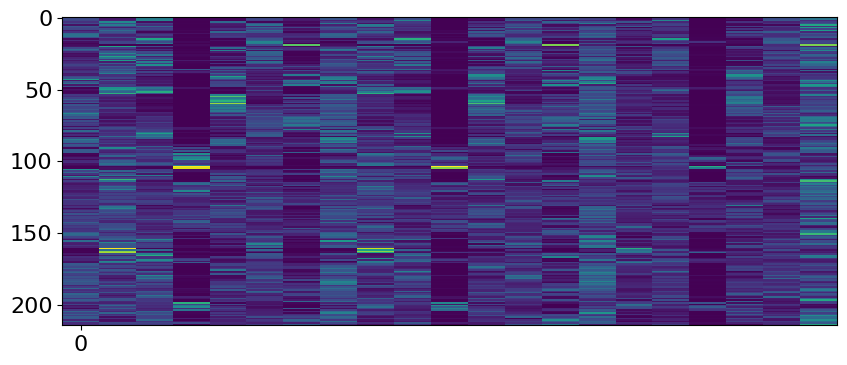

In [209]:
plt.figure(figsize=(10, 4))
plt.imshow(final_matrix, aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

## Prepare design matrix

In [210]:
ori_X = final_matrix.copy()

print(np.shape(ori_X))

(215, 21)


## Pairwise cosyne distances

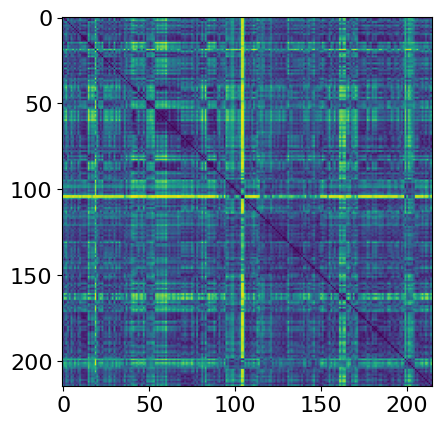

In [211]:
cos_dist = pairwise_distances(ori_X, metric='cosine')
plt.imshow(cos_dist)

/tmp/ipykernel_8718/2923944165.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method='complete', metric='cosine')


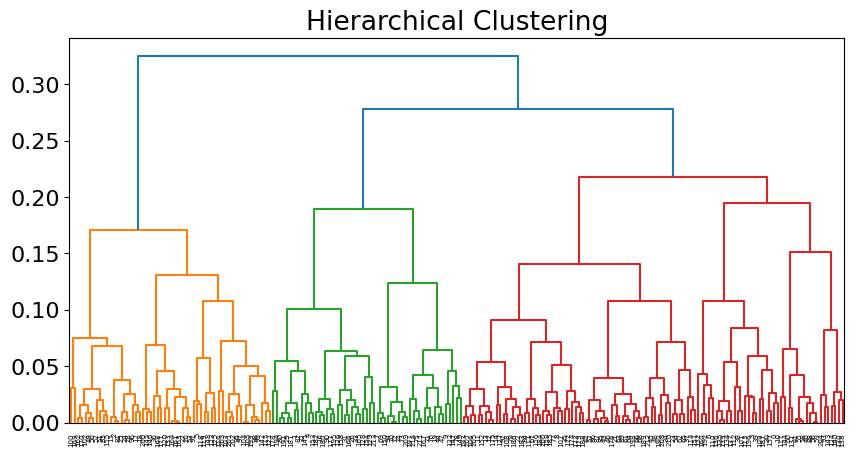

In [212]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine


def plot_dendrogram(distance_matrix, title="Hierarchical Clustering"):
    """
    Performs hierarchical clustering and plots a dendrogram.
    """
    linkage_matrix = sch.linkage(distance_matrix, method='complete', metric='cosine')
    plt.figure(figsize=(10, 5))
    sch.dendrogram(linkage_matrix, leaf_rotation=90)
    plt.title(title)
    plt.show()
    return linkage_matrix
    
linkage_matrix = plot_dendrogram(cos_dist, title="Hierarchical Clustering")

In [213]:
from scipy.cluster.hierarchy import fcluster
k = 3
clusters = fcluster(linkage_matrix, t=k, criterion='maxclust')
design_df['session_cluster'] = clusters 

(array([ 56.,   0.,   0.,   0.,   0.,  53.,   0.,   0.,   0., 106.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

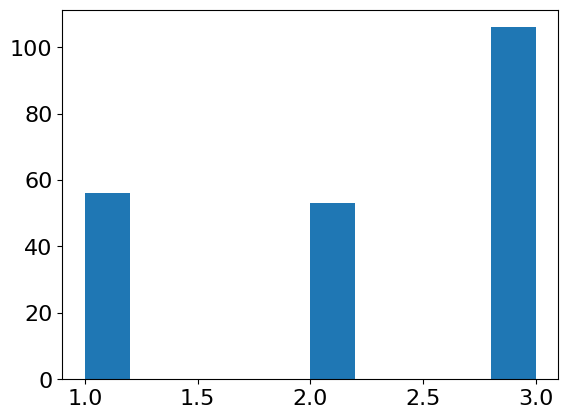

In [214]:
plt.hist(clusters)

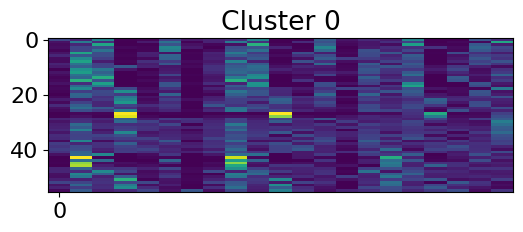

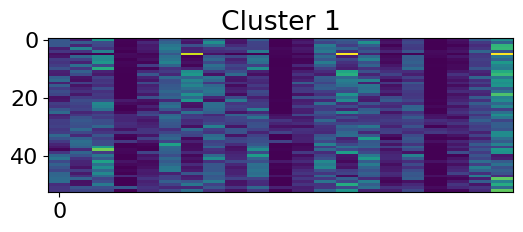

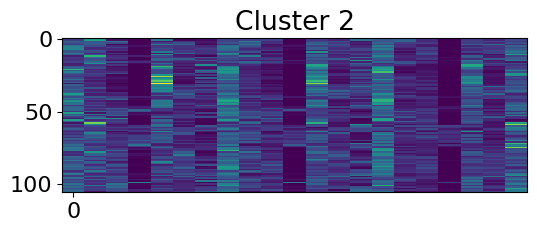

In [215]:
for c, cluster in enumerate(np.unique(clusters)):
    indices = np.where(clusters==cluster)[0]
    data = np.array(final_matrix)[indices, :]
    plt.figure(figsize=(6, 2))
    plt.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))
    plt.title('Cluster ' + str(c))
    plt.show()

/tmp/ipykernel_8718/3417377888.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  new_df = final_matrix.stack(0).unstack()
/tmp/ipykernel_8718/3417377888.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  sequences_choice = np.vstack(use_data[row] for row in [0, 1, 2, 3, 4, 5, 6]) # Transpose to get the right shape
/tmp/ipykernel_8718/3417377888.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  new

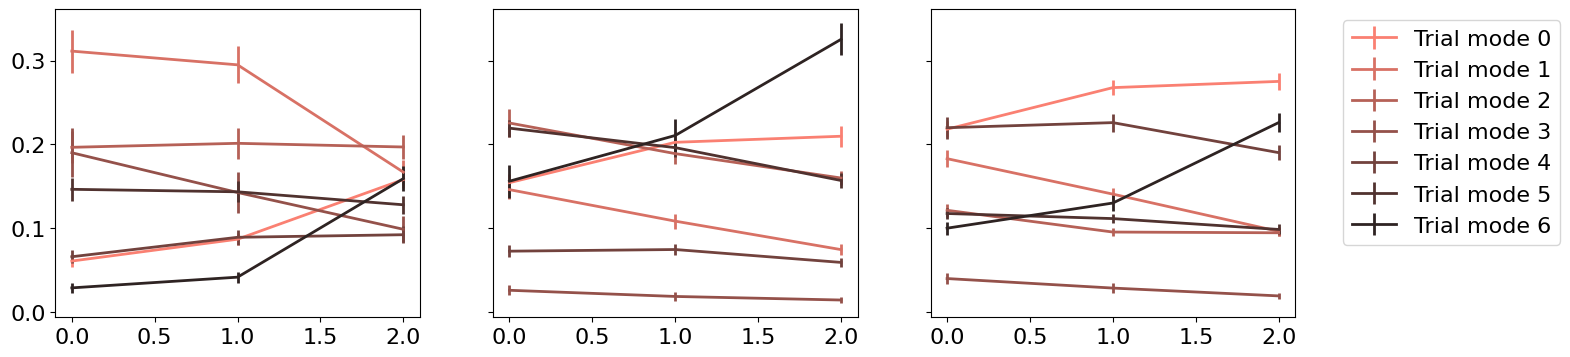

In [216]:
palette = sns.color_palette("dark:salmon_r", 7, as_cmap=False)
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette(palette).as_hex())

fig, axs = plt.subplots(1, len(np.unique(clusters)), sharex=True, sharey=True, figsize=(16, 4))

for c, cluster in enumerate(np.unique(clusters)):
    new_df = final_matrix.stack(0).unstack()
    use_data = new_df.iloc[np.where(clusters==cluster)]
    sequences_choice = np.vstack(use_data[row] for row in [0, 1, 2, 3, 4, 5, 6]) # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    for t, trial in enumerate([0, 1, 2, 3, 4, 5, 6]):
        axs[c].errorbar(np.arange(0, target_length), 
                        np.nanmean(use_data[t], axis=0),
                        np.nanstd(use_data[t], axis=0)/np.sqrt(np.shape(use_data[t])[0]), linewidth=2, 
                        color=my_cmap(t), label=str('Trial mode '+str(t)))
        
axs[2].legend(loc='upper left', bbox_to_anchor=(1.1, 1))



In [217]:
new_df = design_df.droplevel(1, axis=1)[['mouse_name', 'session', 'session_cluster']]

In [222]:
file_to_save = new_df.copy()
filename = "cluster_per_session_dendogram"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = '4.8_clustering_session_sequences_dendogram.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

## Correlates of session clusters

In [140]:
data_path = prefix + 'representation_learning_variability/DATA/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')  
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

/tmp/ipykernel_8718/3499453394.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  learning_df = pd.read_csv(data_path+'learning_private_one.csv')


In [219]:
df = new_df.merge(learning_times, on='mouse_name')

In [220]:
data_path =  prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_parquet(data_path+'training_time_03-21-2025', engine='pyarrow')
learning_times_new = learning_df.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

a = df[['mouse_name', 'training_time']].merge(learning_times_new, on='mouse_name', how='outer')
b = a.loc[a['training_time_x'].isna()]
b = b.rename(columns={"training_time_y": "training_time"}).reset_index()

full_learning = pd.concat([learning_times[['mouse_name', 'training_time']], b[['mouse_name', 'training_time']]]).reset_index()

/tmp/ipykernel_8718/1478564848.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))


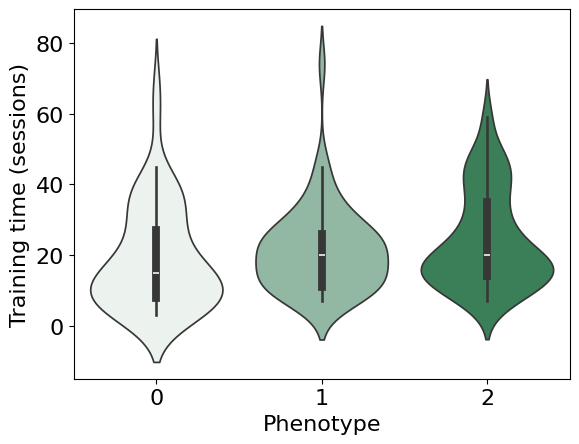

P-value for KW: 0.020
          1         2        3
1  1.000000  0.313108  0.01586
2  0.313108  1.000000  1.00000
3  0.015860  1.000000  1.00000


In [223]:
# --Machine learning and statistics
from scipy.stats import ttest_ind
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

var_1 = 'training_time ~ session_cluster'
var = 'training_time'
# var = 'elongation'
# var_1 = 'elongation ~ part_cluster'
# Define the model using ordinary least squares (OLS) and fit it
data = df.dropna()
# data = df.loc[df['mouse_name'].isin(filter_mice)].dropna()
# data = pd.DataFrame(df.groupby(['mouse_name', 'part_cluster'])[var].mean()).reset_index().dropna()

model = ols(var_1, data=data).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame

# print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=data[var], groups=data['session_cluster'], alpha=0.05)
# print(tukey)

plt.rcParams.update({'font.size': 16})
sns.violinplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.barplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.scatterplot(x='part_cluster', y=var, data=data, color='black')
plt.xticks([0, 1, 2], [0, 1, 2])
# plt.ylim([0, 80])
plt.xlabel('Phenotype')
plt.ylabel('Proportion correct')
plt.ylabel('Training time (sessions)')
plt.show()

group_1 = df.loc[df['session_cluster']==1, var]
group_2 = df.loc[df['session_cluster']==2, var]
group_3 = df.loc[df['session_cluster']==3, var]
# group_4 = df.loc[df['session_cluster']==4, var]


stat, p_value = stats.kruskal(group_1, group_2, group_3)
# stat, p_value = stats.kruskal(group_1, group_2)

print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(df.dropna(), val_col=var, group_col='session_cluster', p_adjust='bonferroni')
print(posthoc)